In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [2]:
image_size = 256
batch_size = 32
channels = 3
epochs = 30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "dataset_of_orange_leaf_disease",
    shuffle= True,
    image_size = (image_size, image_size),
    batch_size = batch_size,
    
)

Found 38434 files belonging to 5 classes.


In [4]:
class_names = dataset.class_names
class_names

['Citrus_Canker_Diseases_Leaf_Orange',
 'Citrus_Nutrient_Deficiency_Yellow_Leaf_Orange',
 'Healthy_Leaf_Orange',
 'Multiple_Diseases_Leaf_Orange',
 'Young_Healthy_Leaf_Orange']

In [5]:
len(dataset)

1202

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 2 1 1 0 0 1 1 1 3 1 0 0 4 1 0 1 2 0 1 1 1 0 1 4 4 4 2 1 1]


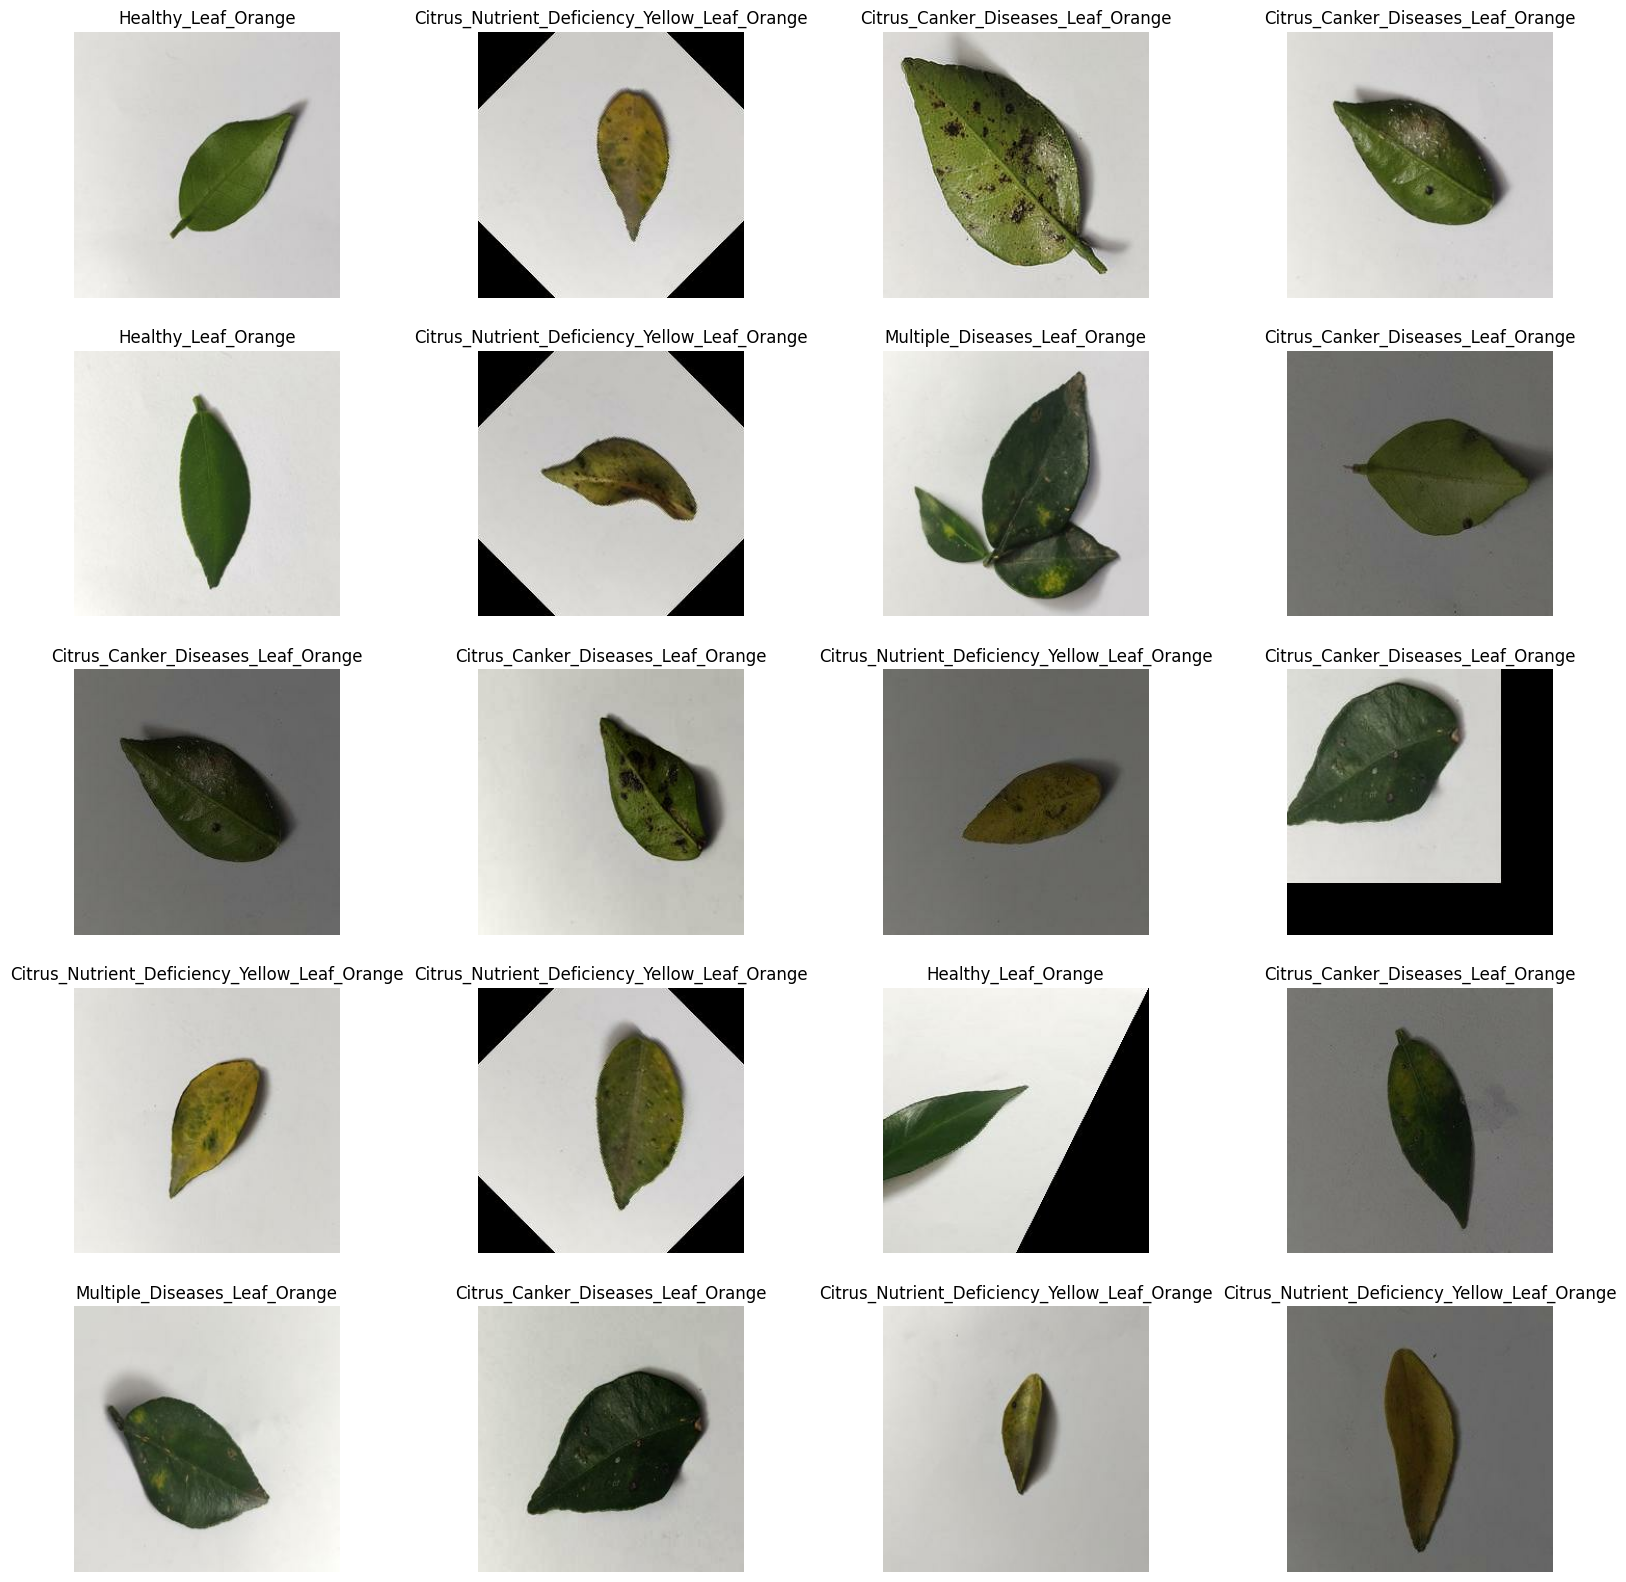

In [7]:
plt.figure(figsize = (20,20))
for image_batch, label_batch in dataset.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
train_size = 0.8 
len(dataset)*train_size 

961.6

In [9]:
train_ds = dataset.take(12)
len(train_ds)

12

In [10]:
test_ds = dataset.skip(12)
len(test_ds)

1190

In [11]:
val_size = 0.1
len(dataset)*val_size

120.2

In [12]:
val_ds = test_ds.take(1)
len(val_ds)

1

In [13]:
test_ds = test_ds.skip(1)
len(test_ds)

1189

In [14]:
def get_dataset_partition_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(ds_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [15]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [16]:
len(train_ds)

1202

In [17]:
len(val_ds)

120

In [18]:
len(test_ds)

121

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(image_size, image_size),
    layers.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomBrightness(0.2)
])

In [22]:
input_shape = (batch_size, image_size, image_size, channels)
n_classes = 5

In [23]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation = "relu", input_shape = input_shape),
    # layers.BatchNormalization(),
    # layers.ReLU(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    # layers.BatchNormalization(),
    # layers.ReLU(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    # layers.BatchNormalization(),
    # layers.ReLU(),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    # layers.BatchNormalization(),
    # layers.ReLU(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    # layers.BatchNormalization(),
    # layers.ReLU(),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = "relu"),
    layers.MaxPooling2D((2,2)),
    # layers.BatchNormalization(),
    # layers.ReLU(),
    layers.Flatten(),
    layers.Dense(64, activation = "relu"),
    # layers.Dropout(0.5),
    layers.Dense(n_classes, activation = "softmax")
])

model.build(input_shape = input_shape)

C:\Users\foyaz\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 5)                     │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,877 (718.27 KB)

 Trainable params: 183,877 (718.27 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# model.compile(
#     optimizer = "adam",
#     loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
#     metrics = ["accuracy"],
# )

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [ ]:
# history = model.fit(
#     train_ds,
#     epochs = epochs,
#     batch_size = batch_size,
#     verbose = 1,
#     validation_data = val_ds
# )


# early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_ds,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=val_ds,
    # callbacks=[early_stopping],
    verbose=1
)

In [ ]:
scores = model.evaluate(test_ds)
scores

In [ ]:
history.params 

In [ ]:
history.history.keys()

In [ ]:
history.history["accuracy"]

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]


In [ ]:
plt.figure(figsize = (10,10))

plt.subplot(1,2,1)
plt.plot(range(len(acc)), acc, label = "Training Accuracy")
plt.plot(range(len(val_acc)), val_acc, label = "Validation Accuracy")

plt.legend(loc = "upper right")
plt.title("Training and Validation Accuracy")